In [43]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import h5py
import pickle
import os
os.chdir("neuron_genetic_alg/neuron_files/allen")
from neuron import h
os.chdir("../../../")
print(os.getcwd())
import sys
import pandas as pd
os.chdir('neuron_genetic_alg')
from config import *
os.chdir('../')


np.set_printoptions(threshold=sys.maxsize)



/global/cscratch1/sd/zladd/axonstandardized/playground/runs/allen_full_11_09_21_488683423/genetic_alg


In [63]:
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

tick_major = 6
tick_minor = 4
plt.rcParams["xtick.major.size"] = tick_major
plt.rcParams["xtick.minor.size"] = tick_minor
plt.rcParams["ytick.major.size"] = tick_major
plt.rcParams["ytick.minor.size"] = tick_minor

font_small = 12
font_medium = 13
font_large = 14
plt.rc('font', size=font_small)          # controls default text sizes
plt.rc('axes', titlesize=font_medium)    # fontsize of the axes title
plt.rc('axes', labelsize=font_medium)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=font_small)    # fontsize of the tick labels
plt.rc('ytick', labelsize=font_small)    # fontsize of the tick labels
plt.rc('legend', fontsize=font_small)    # legend fontsize
plt.rc('figure', titlesize=font_large)   # fontsize of the figure title

# Plot for GA result
def final_indv_plot(param_names, final_best_indv, title, file_path_to_save=None, max_xtic=1, vert_size=10):
    plt.figure(figsize=(cm_to_in(8.5), cm_to_in(vert_size)))
    ax = plt.gca()
    y_pos = np.arange(len(param_names))
    ax.barh(y_pos, final_best_indv, height=0.5, align='center', linestyle='-', color='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(param_names)
    ax.invert_yaxis()  # labels read top-to-bottom
    plt.axvline(x=0, color='black', linewidth=0.4 ,linestyle='--')
    ax.set_xlim(0, max_xtic)
    ax.set_xticks([0, max_xtic])
    ax.set_ylabel('Parameters')
    ax.set_xlabel('Normalized Distance')
    ax.set_title('Deviation From Truth Value ' + title)
    if file_path_to_save:
        plt.savefig(file_path_to_save+'.pdf', format='pdf', dpi=1000, bbox_inches="tight")

# Code for optimization results analysis
def read_and_normalize_with_neg(opt_result_path, base, lower_bounds, upper_bounds):
    with open(opt_result_path, 'rb') as f:
        best_indvs = pickle.load(f, encoding = "latin1")
    normalized_indvs = []
    for i in range(len(best_indvs)):
        normalized = []
        for j in range(len(best_indvs[i])):
            if (best_indvs[i][j] < base[j]):
                new_value = abs((best_indvs[i][j] - base[j])/(ubs[j] - base[j]))
                normalized.append(new_value)
            else:
                new_value = abs((best_indvs[i][j] - base[j])/(ubs[j] - base[j]))
                normalized.append(new_value)
        normalized_indvs.append(normalized)
    return normalized_indvs, best_indvs

def plot_stim_volts_pair(stim, volts, title_stim, title_volts, file_path_to_save=None):
    fig = plt.figure(figsize=(cm_to_in(8.5+6), cm_to_in(12)))
    plt.subplot(2, 1, 1)
    plt.title(title_stim)
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (nA)')
    plt.plot(stim, color='black', linewidth=0.7)
    plt.subplot(2, 1, 2)
    plt.title('Voltage Response '+title_volts)
    plt.xlabel('Time (A.U.)')
    plt.ylabel('Amplitude (mV)')
    plt.plot(volts[0], label='target', color='black')
    plt.plot(volts[1], label='best individual', color='crimson')
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.tight_layout(pad=1)
    plt.show()
    if file_path_to_save:
        fig.savefig(file_path_to_save+'.pdf', format='pdf', dpi=1000, bbox_inches="tight")

def cm_to_in(cm):
    return cm/2.54

# Running a single volt
def run_single_volts(param_set, stim_data, ntimestep, dt):
    run_file = 'neuron_genetic_alg/neuron_files/allen/run_model_cori.hoc'
    h.load_file(run_file)
    total_params_num = len(param_set)
    timestamps = np.array([dt for i in range(ntimestep)])
    h.curr_stim = h.Vector().from_python(stim_data)
    h.transvec = h.Vector(total_params_num, 1).from_python(param_set)
    h.stimtime = h.Matrix(1, len(timestamps)).from_vector(h.Vector().from_python(timestamps))
    h.ntimestep = ntimestep
    h.runStim()
    out = h.vecOut.to_python()
    return np.array(out)

def plot_comb_scores(opt_path, score_path, title, plot_save_path=None):
    opt_result = h5py.File(opt_path)
    try:
        ordered_score_function_list = [e.decode('ascii') for e in opt_result['ordered_score_function_list'][:]]
        optimization_stim_names = [e.decode('ascii') for e in opt_result['opt_stim_name_list'][:]]
    except AttributeError:
        ordered_score_function_list = [e for e in opt_result['ordered_score_function_list'][:]]
        optimization_stim_names = [e for e in opt_result['opt_stim_name_list'][:]]
    optimization_weightes = opt_result['opt_weight_list'][:]
    best_stims_score_list = []
    for score_name in optimization_stim_names:
        curr_score_data = h5py.File(score_path+score_name+'_scores.hdf5', 'r')
        for sf in ordered_score_function_list:
            curr_stim_sf_pair = curr_score_data['norm_pin_scores_'+sf][:]
            best_stims_score_list.append(curr_stim_sf_pair)
    combined_score = sum([best_stims_score_list[i]*optimization_weightes[i] for i in range(len(optimization_weightes))])
    plt.figure(figsize=(cm_to_in(8.5), cm_to_in(5)))
    plt.title(title)
    plt.xlabel('Parameter Set Rank')
    plt.ylabel('Weighted Score')
    time_step = range(len(combined_score))
    plt.scatter(time_step, combined_score, s=1, color='black')
    if plot_save_path:
        plt.savefig(plot_save_path+'.pdf', format='pdf', dpi=1000, bbox_inches="tight")


In [45]:
params_bbp = list(pd.read_csv('./params/params_allen_full.csv').iloc[:,0])
print(params_bbp)

['g_pas_all', 'e_pas_all', 'gNaTa_tbar_NaTa_t_axonal', 'gK_Tstbar_K_Tst_axonal', 'gNap_Et2bar_Nap_Et2_axonal', 'gK_Pstbar_K_Pst_axonal', 'gSKv3_1bar_SKv3_1_axonal', 'gCa_LVAstbar_Ca_LVAst_axonal', 'gCa_HVAbar_Ca_HVA_axonal', 'gSKv3_1bar_SKv3_1_somatic', 'gCa_HVAbar_Ca_HVA_somatic', 'gNaTs2_tbar_NaTs2_t_somatic', 'gCa_LVAstbar_Ca_LVAst_somatic', 'gIh_dend', 'cm_all', 'cm_apical_basal']


In [46]:
gpu_tuned_init_params = list(pd.read_csv('./params/params_allen_full.csv').iloc[:,0])
print(params_bbp)#list(pd.read_csv('neuron_genetic_alg/params/params_bbp_full_gpu_tuned_10_based.csv').iloc[:,1])

['g_pas_all', 'e_pas_all', 'gNaTa_tbar_NaTa_t_axonal', 'gK_Tstbar_K_Tst_axonal', 'gNap_Et2bar_Nap_Et2_axonal', 'gK_Pstbar_K_Pst_axonal', 'gSKv3_1bar_SKv3_1_axonal', 'gCa_LVAstbar_Ca_LVAst_axonal', 'gCa_HVAbar_Ca_HVA_axonal', 'gSKv3_1bar_SKv3_1_somatic', 'gCa_HVAbar_Ca_HVA_somatic', 'gNaTs2_tbar_NaTs2_t_somatic', 'gCa_LVAstbar_Ca_LVAst_somatic', 'gIh_dend', 'cm_all', 'cm_apical_basal']


In [47]:
model_num = str(model_num)


In [48]:
stims = h5py.File("stims/stims_{}.hdf5".format(model_num),"r")
try:
    corresponding_original = np.array([stim.decode("ascii") for stim in stims["corresponding_original"][:]])
    sweep_keys = np.array([stim.decode("ascii") for stim in stims["sweep_keys"][:]])
except:
    corresponding_original = "None"
    sweep_keys = [b'100000', b'10000', b'10000', b'10000', b'10000']
target_volts_path = '../target_volts/target_volts_{}.hdf5'.format(model_num,model_num)
target_volts = h5py.File(target_volts_path, 'r')
#sweep_keys

In [49]:
def match_stim_name(sweep_keys,corresponding_original, name):
    try:
        return sweep_keys[np.argwhere(corresponding_original ==name)[0]][0]
    except:
        print("no match for {}".format(name))
        return np.random.choice(sweep_keys)
    
def pick_stim_name(stims):
    choices = [choice for choice in list(stims.keys()) if "dt" not in choice]
    return np.random.choice(choices)

In [50]:
# test_stim1_name = match_stim_name(sweep_keys, corresponding_original, "65")
# test_stim2_name = match_stim_name(sweep_keys, corresponding_original, "51_2")
# train_stim1_name =match_stim_name(sweep_keys, corresponding_original, "4")
# train_stim2_name = match_stim_name(sweep_keys, corresponding_original, "53_3")
# test_stim1 = stims[test_stim1_name][:]
# test_stim2 = stims[test_stim2_name][:]
# train_stim1 = stims[train_stim1_name][:]
# train_stim2 = stims[train_stim2_name][:]
# test_stim1_dt = stims[test_stim1_name+'_dt'][0]
# test_stim2_dt = stims[test_stim2_name+'_dt'][0]
# train_stim1_dt = stims[train_stim1_name+'_dt'][0]
# train_stim2_dt = stims[train_stim2_name+'_dt'][0]

In [51]:
test_stim1_name = pick_stim_name(stims)
test_stim2_name = pick_stim_name(stims)
train_stim1_name = pick_stim_name(stims)
train_stim2_name =  pick_stim_name(stims)
test_stim1 = stims[test_stim1_name][:]
test_stim2 = stims[test_stim2_name][:]
train_stim1 = stims[train_stim1_name][:]
train_stim2 = stims[train_stim2_name][:]
test_stim1_dt = stims[test_stim1_name+'_dt'][0]
test_stim2_dt = stims[test_stim2_name+'_dt'][0]
train_stim1_dt = stims[train_stim1_name+'_dt'][0]
train_stim2_dt = stims[train_stim2_name+'_dt'][0]

In [52]:
test_target_volts1 = target_volts[test_stim1_name][:]
test_target_volts2 = target_volts[test_stim2_name][:]
train_target_volts1 = target_volts[train_stim1_name][:]
train_target_volts2 = target_volts[train_stim2_name][:]

In [53]:
bbp_full_allen_opt_path = './objectives/multi_stim_without_sensitivity_allen_full_11_09_21_stims.hdf5'

bbp_full_allen_score_path = '../scores/'
bbp_full_allen_plot_path = './plots/'
# plot_comb_scores(bbp_full_allen_opt_path, bbp_full_allen_score_path, 'Full BBP Allen', bbp_full_allen_plot_path)
# print('Stims used to train:')
train_stim_names = h5py.File(bbp_full_allen_opt_path, 'r')['opt_stim_name_list'][:]
# for e in train_stim_names:
#     print(e)#.decode('ascii'))


In [54]:
run_name = 'zero_penalty'
run_name = "GPU"

In [55]:
import pickle

# with open('neuron_genetic_alg/best_indv_logs/best_indvs_gen_5.pkl', 'rb') as f:
#     g = pickle.load(f)

[3.08188223e-06 7.97002747e+01 9.62994393e-01 7.63818647e-01
 9.31381279e-04 2.88031807e-01 2.89891782e+00 7.53555214e-02
 1.74757968e-03 1.15853854e-01 1.93620974e-04 1.21046158e+00
 5.08450037e-04 2.57487507e-04 2.32000000e+00 5.00000000e-01]


[4.450530558420534e-06,
 92.62261628226696,
 1.2725887309995683,
 7.611945329937381,
 0.0002706077808004801,
 1.8472863814971874,
 0.8347566811871325,
 3.4536133527475923,
 0.08454867055052927,
 0.33725213436030715,
 0.0002306995021957393,
 1.8642409821250483,
 0.06085660752028611,
 0.00037554873876942884,
 1.8953038495052525,
 0.5359315863223963]

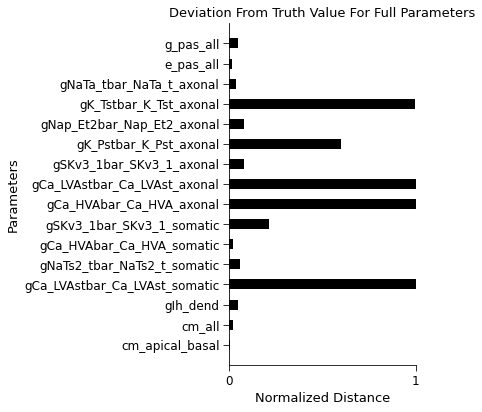

In [71]:
GA_result_path = 'neuron_genetic_alg/best_indv_logs/best_indvs_gen_12.pkl'

params_path = './params/params_allen_full.csv'
df = pd.read_csv(params_path, skipinitialspace=True, usecols=['Base value'])
base_full = df.values.T[0]
#base_full = bbp_params_base
# opt_ind = [0,1,6,9,13,14,15]

opt_ind = np.arange(16)
base = [base_full[i] for i in opt_ind]
lbs = [0.1*p for p in base]
ubs = [10*p for p in base]
params_bbp_full = [params_bbp[i] for i in opt_ind]
normalized_indvs_full_bbp, best_indvs_full_bbp = read_and_normalize_with_neg(GA_result_path, base, lbs, ubs)
file_path_to_save = './plots/'
final_indv_plot(params_bbp_full, normalized_indvs_full_bbp[-1], 'For Full Parameters', file_path_to_save, 1, 16)
print(base_full)
best_indvs_full_bbp[-1]

In [72]:
df = pd.read_csv(params_path, skipinitialspace=True, usecols=['Param name','Lower bound', 'Upper bound'])
lbs = df['Lower bound']
ubs = df['Upper bound']
names = df['Param name']

In [74]:
best_full = list(base_full)

for i in range(len(opt_ind)):
    best_full[opt_ind[i]] = best_indvs_full_bbp[-1][i]
best_full[1] = - best_full[1]




print("\n\n")
count = 0
for best, lb, ub, name in zip(best_full, lbs, ubs, names):
    if count in opt_ind:
        print(count, "(optimized)", "name :", name, " | best: ", round(best,9) , " | lb: ", round(lb,8), " | ub: ", round(ub,8))

    else:
        print(count, "name :", name, " | best: ", round(best,9) , " | lb: ", round(lb,8), " | ub: ", round(ub,8))
    print("------------------------------------------------------------")
    count += 1
    




0 (optimized) name : g_pas_all  | best:  4.451e-06  | lb:  1e-08  | ub:  3.082e-05
------------------------------------------------------------
1 (optimized) name : e_pas_all  | best:  -92.622616282  | lb:  53.76021972  | ub:  118.61035705
------------------------------------------------------------
2 (optimized) name : gNaTa_tbar_NaTa_t_axonal  | best:  1.272588731  | lb:  0.09629944  | ub:  9.62994393
------------------------------------------------------------
3 (optimized) name : gK_Tstbar_K_Tst_axonal  | best:  7.61194533  | lb:  0.07638186  | ub:  17.63818647
------------------------------------------------------------
4 (optimized) name : gNap_Et2bar_Nap_Et2_axonal  | best:  0.000270608  | lb:  9.314e-05  | ub:  0.00931381
------------------------------------------------------------
5 (optimized) name : gK_Pstbar_K_Pst_axonal  | best:  1.847286381  | lb:  0.02880318  | ub:  4.88031807
------------------------------------------------------------
6 (optimized) name : gSKv3_1bar

In [75]:
# best_full = pd.read_csv('params/params_allen_full.csv')['Base value']
# best_full[0] = 1.9e-07
# best_full[1] = - best_full[1] #125
# # best_full
# best_full[7] = 10

finshed run matrix


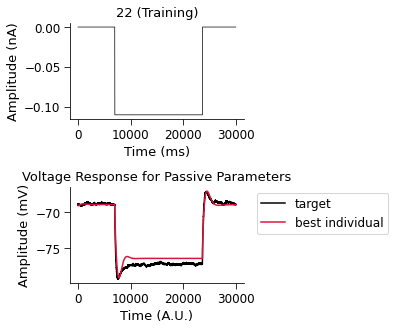

finshed run matrix


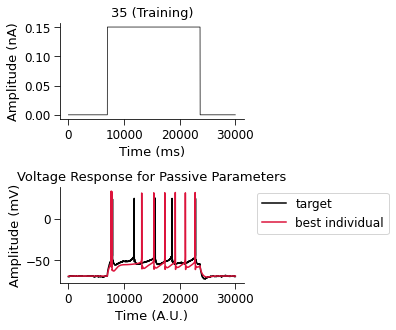

-73.11092883534533


In [76]:
train_volts_full_best_response1 = run_single_volts(best_full, train_stim1, ntimestep=ntimestep, dt=train_stim1_dt)
file_save_path = './plots/'
plot_stim_volts_pair(train_stim1, [train_target_volts1, train_volts_full_best_response1], train_stim1_name+' (Training)', 'for Passive Parameters', file_save_path)

train_volts_full_best_response2 = run_single_volts(best_full, train_stim2, ntimestep=ntimestep, dt=train_stim2_dt)
file_save_path = './plots/'
plot_stim_volts_pair(train_stim2, [train_target_volts2, train_volts_full_best_response2], train_stim2_name+' (Training)', 'for Passive Parameters', file_save_path)

print(np.mean(train_volts_full_best_response1))


<KeysViewHDF5 ['12', '12_dt', '13', '13_dt', '14', '14_dt', '15', '15_dt', '16', '16_dt', '17', '17_dt', '18', '18_dt', '19', '19_dt', '20', '20_dt', '21', '21_dt', '22', '22_dt', '23', '23_dt', '28', '28_dt', '30', '30_dt', '31', '31_dt', '34', '34_dt', '35', '35_dt', '36', '36_dt', '38', '38_dt', '4', '43', '43_dt', '44', '44_dt', '46', '46_dt', '47_1', '47_1_dt', '47_2', '47_2_dt', '47_3', '47_3_dt', '48_1', '48_1_dt', '48_2', '48_2_dt', '48_3', '48_3_dt', '4_dt', '5', '50_1', '50_1_dt', '50_2', '50_2_dt', '50_3', '50_3_dt', '51_1', '51_1_dt', '51_2', '51_2_dt', '51_3', '51_3_dt', '53_1', '53_1_dt', '53_2', '53_2_dt', '53_3', '53_3_dt', '56', '56_dt', '57', '57_dt', '58', '58_dt', '59', '59_dt', '5_dt', '6', '64', '64_dt', '65', '65_dt', '66', '66_dt', '68', '68_dt', '6_dt', '8', '8_dt', '9', '9_dt']>
15 [0.02]
finshed run matrix
mean response:  -68.58758755188876  v init :  -68.40626


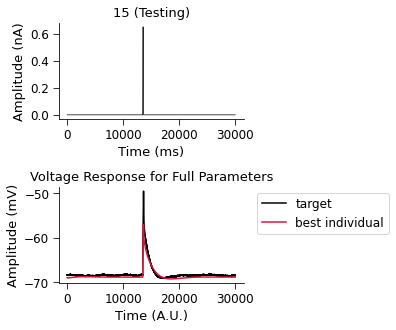

19 [0.02]
finshed run matrix
mean response:  -68.56450757911244  v init :  -68.125


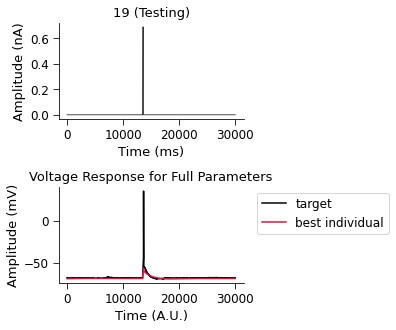

22 [0.06]
finshed run matrix
mean response:  -73.11092883534533  v init :  -68.875


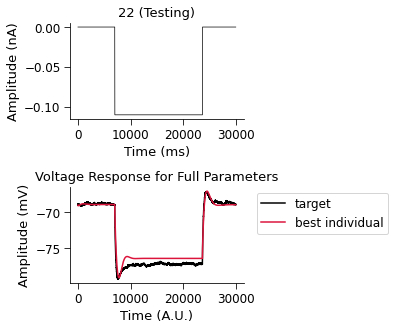

35 [0.06]
finshed run matrix
mean response:  -61.52341813671647  v init :  -69.62501


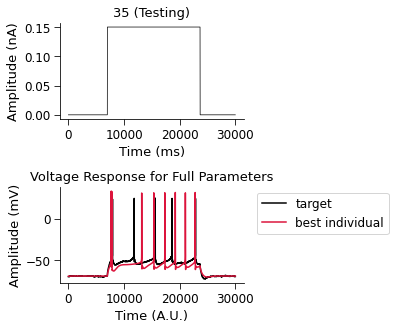

38 [0.06]
finshed run matrix
mean response:  -61.00396586107931  v init :  -69.00001


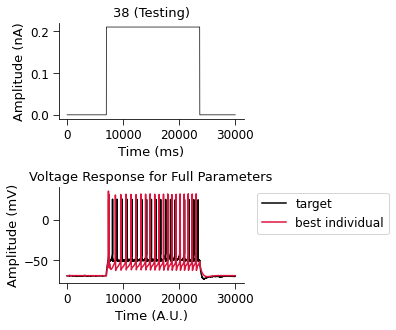

47_2 [0.165]
finshed run matrix
mean response:  -60.614275662739345  v init :  -67.8125


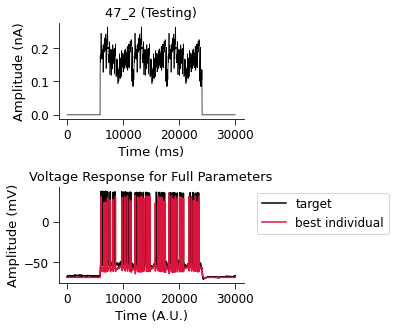

58 [0.095]
finshed run matrix
mean response:  -59.19003672633208  v init :  -70.15626


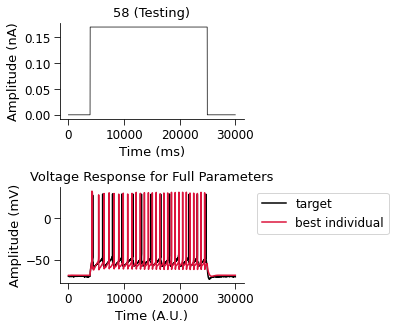

59 [0.095]
finshed run matrix
mean response:  -59.19003672633208  v init :  -71.125


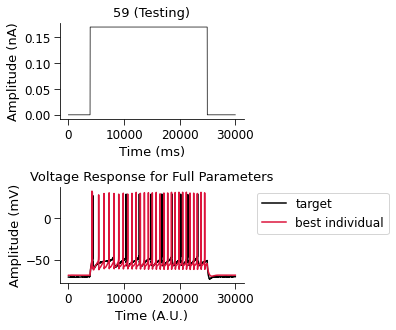

In [77]:
# test_volts_full_best_response1 = run_single_volts(best_full, test_stim1, ntimestep=10000, dt=test_stim1_dt)
# file_save_path = './plots/'
# plot_stim_volts_pair(test_stim1, [test_target_volts1, test_volts_full_best_response1], test_stim1_name+' (Testing)', 'for Full Parameters', file_save_path)

# print(np.mean(test_volts_full_best_response1))

print(stims.keys())
# mylist = ['39', '39_dt', '41', '41_dt', '42', '42_dt', '43', '43_dt', '44', '44_dt', '45', '45_dt', '46', '46_dt', '47', '47_dt', '48', '48_dt', '52', '52_dt', '55_1', '55_1_dt', '55_2', '55_2_dt', '55_3', '55_3_dt', '6', '60_1', '60_1_dt', '60_2', '60_2_dt', '60_3', '60_3_dt', '65', '65_dt', '68', '68_dt', '6_dt', '7', '71', '71_dt', '75', '75_dt', '7_dt', '8', '8_dt', '9', '9_dt']
# below is list used to train GA
# mylist = ['47', '46', '44', '43', '45', '42', '75', '41', '65', '68', '6', '71', '52', '48', '39', '38', '19', '37', '17', '18']
# mylist = ['18','17', '47', '46', '44', '43', '45', '42', '75', '41', '65', '68', '6', '71', '52', '48', '39', '38', '19', '37', '17', '18']
# mylist = reversed(list(stims.keys()))
# mylist = list(stims.keys())

mylist = ['15','19','22', '35','38','47_2','58', '59']
# mylist = ['5']
# mylist = ['35','38','47_2','58']


for test_stim_name in mylist:#reversed(list(stims.keys())):
    if "dt" in test_stim_name:
        continue
    test_stim = stims[test_stim_name][:]
#     test_stim_name = '68'
    test_stim2_dt = stims[test_stim_name + '_dt']
    print(test_stim_name, test_stim2_dt[:])
    # test_stim2_dt = min(.08,test_stim2_dt[0])
    response = run_single_volts(best_full, test_stim, ntimestep=ntimestep, dt=test_stim2_dt)
    file_save_path = f'./plots/{test_stim_name}'
    targV = target_volts[test_stim_name][:]
    print('mean response: ', np.mean(response),' v init : ', targV[0] )
    plot_stim_volts_pair(test_stim, [targV, response], test_stim_name+' (Testing)', 'for Full Parameters', file_save_path)
    fig = plt.figure(figsize=(15,8))
    plt.plot(targV, color='black', label='target')
    plt.plot(response, color='red', label='simulated')
    plt.legend()
    plt.ylabel('Vm (mV)')
    plt.xlabel('Timestep (A.U.)')
    plt.savefig(f'plots/{test_stim_name}.png')
    plt.close()
#-59.61573578977873

(4000.0, 12000.0)

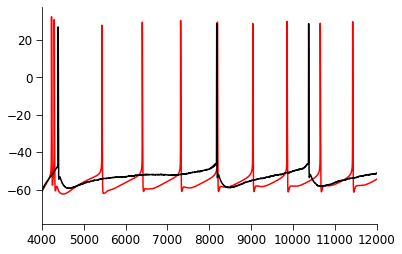

In [78]:
plt.plot(response, color='red')
plt.plot(targV, color='black')
plt.xlim(4000,12000)

(4000.0, 12000.0)

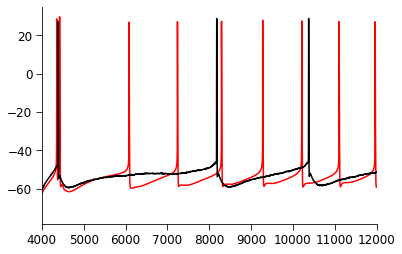

In [20]:
plt.plot(response, color='red')
plt.plot(targV, color='black')
plt.xlim(4000,12000)

In [133]:
'6', '27', '26', '60_3', '55_3', '55_1', '52', '60_1', '44',
       '60_2', '42', '32', '13'

IndentationError: unexpected indent (<ipython-input-133-08b964da25a6>, line 2)

In [ ]:
train_stim_names

In [ ]:
train_stim_names = h5py.File(bbp_full_allen_opt_path, 'r')['opt_stim_name_list'][:]


In [28]:
f = h5py.File(bbp_full_allen_opt_path, 'r')

In [29]:
f.close()

Index(['Param name', 'Lower bound', 'Upper bound'], dtype='object')

In [18]:
full_df = pd.read_csv(params_path, skipinitialspace=True)
full_df_copy = pd.read_csv(params_path, skipinitialspace=True)

In [21]:
best_full = np.array(best_full)
full_df['Base value'] = best_full
full_df['Lower bound'] = best_full / 10
full_df['Upper bound'] = best_full * 10

if 'e_pas' in full_df['Param name'][1]:
    full_df.loc[1,'Base value'] = abs(best_full[1])
    full_df.loc[1,'Lower bound'] = abs(best_full[1])*.8
    full_df.loc[1,'Upper bound'] = abs(best_full[1])*1.3

full_df.iloc[14:16] = full_df_copy.iloc[14:16]
# if 'cm' in full_df['Param name'][14]:
#     full_df.loc[14,'Base value'] = abs(best_full[14])
#     full_df.loc[14,'Upper bound'] = abs(best_full[14])*1.3
#     full_df.loc[14,'Lower bound'] = abs(best_full[14])*.8
    
    
    
# if 'cm' in full_df['Param name'][15]:
#     full_df.loc[15,'Base value'] = abs(best_full[14])
#     full_df.loc[14,'Upper bound'] = abs(best_full[14])*1.3
#     full_df.loc[14,'Lower bound'] = abs(best_full[14])*.8

In [22]:
full_df.to_csv('params/params_allen_full.csv', index=False)

In [93]:
import os

os.listdir('../../../')

['.ipynb_checkpoints',
 'stims',
 'param_stim_generator',
 'genetic_alg',
 '.ipython',
 'analyze_p_bbp_full',
 'input.txt',
 'plot_runs.ipynb',
 'volts_sandbox_setup',
 'run.sh',
 'hoc_evaluator_allen.py',
 '.gitignore',
 'extract_results.sh',
 'modifySandboxArray.py',
 'plots',
 'runs',
 'params',
 'run_allen.sh',
 'modifyEvaluator.py',
 'run_volts',
 'input_templates',
 'score_volts_efficent_sandbox',
 'log.py',
 'params.pkl']

In [95]:
import shutil

shutil.copyfile('params/params_allen_full.csv','../../../params/params_allen_full.csv')

'../../../params/params_allen_full.csv'